In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from astropy.io import ascii
from astropy.table import Table
import athena_read as ar
from glob import glob
from Constants import Constants
import planet_wind_utils as pw
c = Constants()

%matplotlib inline

# set some global options
plt.rcParams['figure.figsize'] = (6,5)
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.borderpad'] = 0.2
plt.rcParams['legend.labelspacing'] = 0.2
plt.rcParams['legend.handletextpad'] = 0.2
#plt.rcParams['font.family'] = 'stixgeneral'
#plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 14

plt.rcParams['font.family']='sans-serif'
plt.rcParams['font.sans-serif']='DejaVu Sans' #, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif
plt.rcParams['mathtext.fontset']='dejavusans'


Constants defined...


In [2]:
from astropy.convolution import convolve, Box1DKernel


def vac_to_air(wav):
    """wav in angstroms"""
    s = 1e4/wav
    n = 1 + 0.0000834254 + 0.02406147 / (130 - s**2) + 0.00015998 / (38.9 - s**2)
    return n

def get_sigmab(d,sep,rp,nanthresh=1e-13):
    selshell = (d['gx1v']>0.5*orb['sep'][0]) & (d['gx1v']<2.0*orb['sep'][0])
    dens_shell = np.where(selshell,d['r0']*d['rho'],0)
    b = (d['x3v']-np.pi)*sep
    sigma = np.sum(dens_shell*d['gdr'],axis=2)[:,0]
    sigma=np.where(sigma>nanthresh,sigma,np.nan)
    #sigma=np.where(np.abs(b)>rp,sigma,0)
    velr = np.sum(dens_shell*d['gdr']*-d['vel1'],axis=2)[:,0]/sigma
    sel = np.abs(b)>rp
    return b[sel],sigma[sel],velr[sel]


def read_get_sigmab(base_dir,fn,level,x1_min,x1_max,x3range=np.pi,nanthresh=1.e-13,
                   makeplot=True):
    """ read file from directory and compute column values """
    orb = pw.read_trackfile(base_dir+"pm_trackfile.dat")
    x2sliceval = pw.get_midplane_theta(base_dir+fn,level=level)
    sep = orb['sep'][0]

    d = pw.read_data(base_dir+fn,orb,
                     level=level,
                     get_cartesian=True,
                     x2_min=x2sliceval,x2_max=x2sliceval,
                     x1_min = x1_min, 
                     x1_max = x1_max,
                     x3_min = np.pi - x3range,
                     x3_max = np.pi + x3range,
                     gamma=1.0001)
    d1 = d['x1f'][1:] - d['x1f'][:-1]
    d['gdr']=np.broadcast_to(d1,(len(d['x3v']),len(d['x2v']),len(d['x1v'])) )

 
    
    # parse filename to get rp
    #rp = int(base_dir[-2:-1])
    #rp=np.where(rp==5,0.5,rp)
    #rp*=7e9
    rp = 1.49e10
    
    b,sigma,velr  = get_sigmab(d,sep,rp,nanthresh=nanthresh)
  
    return d,sep,b,sigma,velr


def sliceplot(d,sep):
    
    plt.figure(figsize=(5,4) )
    plt.pcolormesh(d['x'][:,0,:]/c.au,
                   d['y'][:,0,:]/c.au,
                   np.log10(d['rho'])[:,0,:] ,
                   cmap=plt.cm.Blues,vmax=-16,vmin=-22)
    plt.colorbar(label=r"$\log_{10} \left( \rho \right)$",extend='both')

    plt.axis('equal')

    lim = sep*2
    plt.xlim(-lim/c.au,lim/c.au)
    plt.ylim(-lim/c.au,lim/c.au)
    plt.xlabel('$x$ [au]')
    plt.ylabel('$y$ [au]')
    #plt.show()
    
    
    
def lineplot(sep,b,sigma,vr):
    db = b[1]-b[0]
    width = 2*rstar/db
    sigmac = convolve(sigma,Box1DKernel(width),nan_treatment='fill',fill_value=np.nan)
    vrc = convolve(vr,Box1DKernel(width) ,nan_treatment='fill',fill_value=np.nan)


    plim=rstar/sep/(2*np.pi)*5

    plt.figure()
    plt.subplot(211)
    plt.semilogy(-b/sep/(2*np.pi),sigma,'-',lw=2,color='k')
    plt.semilogy(-b/sep/(2*np.pi),sigmac,'--',lw=2,color='r')
    plt.xlim(-plim,plim)
    plt.xticks(visible=False)
    plt.axvline(0,zorder=0,color='grey')
    plt.axvline(-rstar/sep/(2*np.pi),zorder=0,color='grey',ls=':')
    plt.axvline(rstar/sep/(2*np.pi),zorder=0,color='grey',ls=':')
    plt.ylabel(r"$\Sigma$ [g cm$^{-2}$]")

    plt.subplot(212)
    plt.plot(-b/sep/(2*np.pi),vr/1e5,'-',lw=2,color='k')
    plt.plot(-b/sep/(2*np.pi),vrc/1e5,'--',lw=2,color='r')
    plt.plot(-b/sep/(2*np.pi),np.sin(-b/sep) * np.sqrt( c.G*c.msun/sep ) / 1.e5,zorder=0,label='planet frame' )
    plt.xlim(-plim,plim) 
    plt.axhline(0,ls='--',color='grey',zorder=0)
    plt.axvline(0,zorder=0,color='grey')
    plt.axvline(-rstar/sep/(2*np.pi),zorder=0,color='grey',ls=':')
    plt.axvline(rstar/sep/(2*np.pi),zorder=0,color='grey',ls=':')
    plt.ylim(-30,30)
    plt.ylabel(r"$v_{\rm los}$ [km s$^{-1}$]")
    plt.xlabel('phase')
    
    plt.subplots_adjust(hspace=0)
    #plt.show()    

def makefig(d,sep,b,sigma,vr,title=None):

    fig = plt.figure(figsize=(5.5,8))
    f1,f2 = fig.subfigures(nrows=2,ncols=1,height_ratios=[1.5,1])
    f1.subplots()
    plt.pcolormesh(d['x'][:,0,:]/c.au,
                   d['y'][:,0,:]/c.au,
                   np.log10(d['rho'])[:,0,:] ,
                   cmap=plt.cm.Blues,vmax=-16,vmin=-22)
    plt.colorbar(label=r"$\log_{10} \left( \rho\right)$  [g cm$^{-3}$]",extend='both')

    plt.axis('equal')

    lim = sep*2
    plt.xlim(-lim/c.au,lim/c.au)
    plt.ylim(-lim/c.au,lim/c.au)
    plt.xlabel('$x$ [au]')
    plt.ylabel('$y$ [au]')
    plt.title(title)


    db = b[1]-b[0]
    width = 2*rstar/db
    sigmac = convolve(sigma,Box1DKernel(width),nan_treatment='fill',fill_value=np.nan)
    vrc = convolve(vr,Box1DKernel(width) ,nan_treatment='fill',fill_value=np.nan)


    plim= 0.3 #rstar/sep/(2*np.pi)*5
    

    a1,a2 = f2.subplots(2,1)
    a1.semilogy(-b/sep/(2*np.pi),sigma,'-',lw=2,color='k')
    a1.semilogy(-b/sep/(2*np.pi),sigmac,'--',lw=2,color='r')
    a1.set_xlim(-plim,plim)
    a1.set_xticks([],visible=False)
    a1.axvline(0,zorder=0,color='grey')
    a1.axvline(-rstar/sep/(2*np.pi),zorder=0,color='grey',ls=':')
    a1.axvline(rstar/sep/(2*np.pi),zorder=0,color='grey',ls=':')
    a1.set_ylabel(r"$\Sigma$ [g cm$^{-2}$]")
    #a1.set_ylim(2.e-10,2e-7)
    


    a2.plot(-b/sep/(2*np.pi),vr/1e5,'-',lw=2,color='k')
    a2.plot(-b/sep/(2*np.pi),vrc/1e5,'--',lw=2,color='r')
    a2.plot(-b/sep/(2*np.pi),np.sin(-b/sep) * np.sqrt( c.G*c.msun/sep ) / 1.e5,zorder=0,label='planet frame' )
    a2.set_xlim(-plim,plim) 
    a2.axhline(0,ls='--',color='grey',zorder=0)
    a2.axvline(0,zorder=0,color='grey')
    a2.axvline(-rstar/sep/(2*np.pi),zorder=0,color='grey',ls=':')
    a2.axvline(rstar/sep/(2*np.pi),zorder=0,color='grey',ls=':')
    a2.set_ylim(-100,100)
    a2.set_ylabel(r"$v_{\rm los}$ [km s$^{-1}$]")
    a2.set_xlabel('phase')

    f2.subplots_adjust(hspace=0,right=0.8)

In [3]:
## PLANET PARAMETERS

Ms = 1.325*c.msun
Rs = 1.69*c.rsun
Mp = 1.465*1.899e30
Rp = 0.1178*Rs
a = 0.0234*c.au

Nbox = 5 # number of planet radii in refinement box
lmax = 4 

dr_o_r = 10**(3/192) - 1

mdot_planet = 1.e12
lambda_planet = 3.0
mdot_star = 1.e12


print("Mstar = ",Ms)
print("Rstar = ",Rs)

print("Mplanet = ",Mp)
print("Rplanet = ",Rp)

print("Nzones (Rplanet) = ",(Rp/a) / (dr_o_r/2**lmax) )

print("Hill sphere/Rplanet = ", a*(Mp/(3*Ms))**(1/3.)/Rp)

print("a/Rplanet = ",a/Rp)
print("a/Rs = ",a/Rs)

print("T (\lam = 10):", 0.6*c.mp * (c.G*Mp/(10*Rp))/c.kB )
print("Lambda (Teq):", (c.G*Mp/Rp) * (0.6*c.mp/(c.kB*2592) ) )

Mstar =  2.635425e+33
Rstar =  117539500000.0
Mplanet =  2.782035e+30
Rplanet =  13846153100.0
Nzones (Rplanet) =  17.275476039459555
Hill sphere/Rplanet =  1.784905437818908
a/Rplanet =  25.282401362440517
a/Rs =  2.978266880495493
T (\lam = 10): 9747.260610035502
Lambda (Teq): 37.60517210661845


In [4]:
print(
"""
<job>
problem_id = PW     # problem ID: basename of output filenames

<output1>
file_type  = hdf5        # Binary data dump
variable   = prim       # variables to be output
dt         = """ + str( 2*np.pi * np.sqrt(a**3/(c.G*Ms)) ) + """     # time increment between outputs 

xdmf = 1

<output2>
file_type  = hst      # history
dt         = 1e3   # time increment between outputs

<output3>
file_type  = rst      # restart
dt         = 1.0e99     # time increment between outputs

<NOoutput4>
file_type  = hdf5        # Binary data dump
variable   = prim       # variables to be output
dt         = 1e4      # time increment between outputs
xdmf = 0
x2_slice = 1.5707963267948966

<time>
cfl_number = 0.3        # The Courant, Friedrichs, & Lewy (CFL) Number
nlim       = -1       # cycle limit
tlim       = """ +  str( 6 * 2*np.pi * np.sqrt(a**3/(c.G*Ms)) ) + """ # time limit
integrator = vl2
xorder = 2

<mesh>
nx1        = 192        # Number of zones in X1-direction
x1rat      = 1.036303443436363       # ratio between adjacent cell sizes
x1min      = """ + str(Rs) + """        # minimum value of X1
x1max      = """ + str(1000*Rs) + """       # maximum value of X1
ix1_bc     = user   # inner-X1 boundary flag
ox1_bc     = user    # outer-X1 boundary flag

nx2        = 96             # Number of zones in X2-direction
x2min      = 0            # minimum value of X2
x2max      = 3.141592653589793   # maximum value of X2
ix2_bc     = polar        # inner-X2 boundary flag
ox2_bc     = polar        # outer-X2 boundary flag

nx3        = 192          # Number of zones in X3-direction
x3min      = 0.0 # minimum value of X3
x3max      = 6.2831853071795862 # maximum value of X3
ix3_bc     = periodic        # inner-X3 boundary flag
ox3_bc     = periodic        # outer-X3 boundary flag


refinement =  static

<refinement1>
## Box around planet
level = """ + str(lmax) + """
x1min = """ + str(a - Nbox*Rp) +  """
x1max = """ + str(a + Nbox*Rp) +  """
x2min = """ + str(np.pi/2 - Nbox*Rp/a) +  """
x2max = """ + str(np.pi/2 + Nbox*Rp/a) +  """
x3min = """ + str(np.pi - Nbox*Rp/a) +  """
x3max = """ + str(np.pi + Nbox*Rp/a) +  """

<NOrefinement2>
## torus
level = 1
x1min = """ + str(a/2) +  """
x1max = """ + str(3*a/2) +  """
x2min = 0.78539816339
x2max = 2.35619449019
x3min = 0
x3max = 6.2831853071795862




<meshblock>
nx1        = 16         # Number of zones per MeshBlock in X1-direction
nx2        = 16         # Number of zones per MeshBlock in X2-direction
nx3        = 16         # Number of zones per MeshBlock in X3-direction

<hydro>
gamma           = 1.0001 #1.6666666666666667  # gamma = C_p/C_v
iso_sound_speed = 1.0
dfloor = 3.e-25
pfloor = 3.e-12

polar_average = true


<problem>
Ggrav           = 6.674e-8

## orbit 
sma             = """ + str(a) +  """
ecc             = 0.0

### planet
M2              = """ + str(Mp) +  """
mdot_planet     = """ + str(mdot_planet) +  """
lambda_planet   = """ + str(lambda_planet) +  """
f_corotation_planet = 1.0
radius_planet = """ + str(Rp) +  """
rsoft2      =   """ + str(Rp/5) +  """
aniso_heat  =   false

### star
M1   = """ + str(Ms) +  """
mdot_star = """ + str(mdot_star) +  """
lambda_star = 12.5
f_corotation_star = 1.0
star_mode = 2 # 1=Accrete, 2=Wind
t_sw_on = 0.0


### numerical
corotating_frame = 1 # flag whether to do simulation in frame that rotates around COM at initial orbital frequency
gas_backreaction = 0 # flag to include gas effect on orbit
n_particle_substeps = 1 # how many particle integration substeps per timestep?

## ambient "background"
damb = 1.e-24
pamb = 3.e-11

### trackfile output 
trackfile_dt = 1.e3  # dt for printing particle properties

""" )


<job>
problem_id = PW     # problem ID: basename of output filenames

<output1>
file_type  = hdf5        # Binary data dump
variable   = prim       # variables to be output
dt         = 98125.66498203918     # time increment between outputs 

xdmf = 1

<output2>
file_type  = hst      # history
dt         = 1e3   # time increment between outputs

<output3>
file_type  = rst      # restart
dt         = 1.0e99     # time increment between outputs

<NOoutput4>
file_type  = hdf5        # Binary data dump
variable   = prim       # variables to be output
dt         = 1e4      # time increment between outputs
xdmf = 0
x2_slice = 1.5707963267948966

<time>
cfl_number = 0.3        # The Courant, Friedrichs, & Lewy (CFL) Number
nlim       = -1       # cycle limit
tlim       = 588753.989892235 # time limit
integrator = vl2
xorder = 2

<mesh>
nx1        = 192        # Number of zones in X1-direction
x1rat      = 1.036303443436363       # ratio between adjacent cell sizes
x1min      = 117539500000.0

In [5]:
# Checking for steady state...

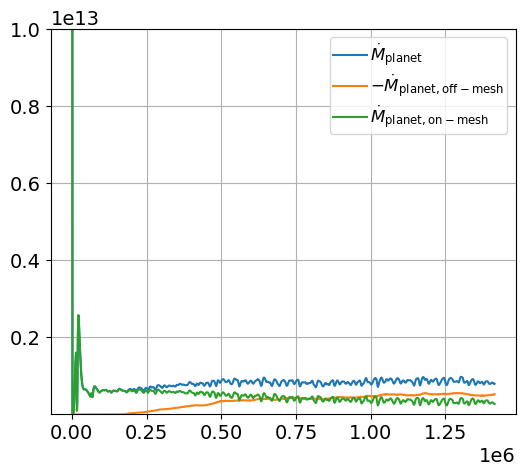

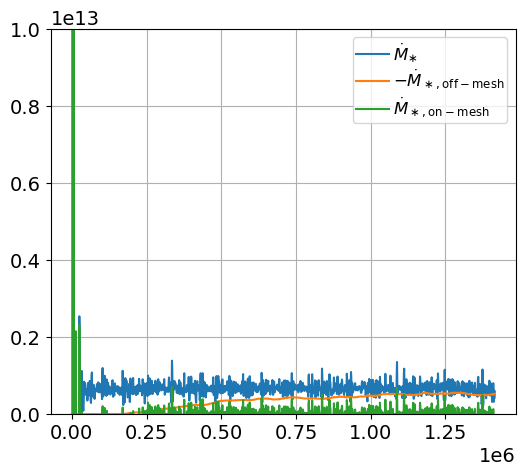

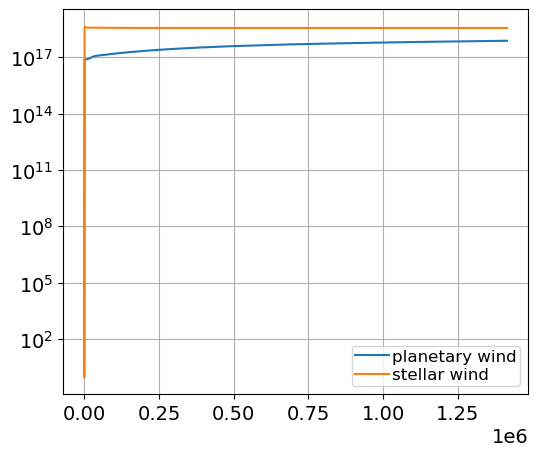

mdotP =  11.934758445099895
mdotS =  11.820732668873637


In [7]:
hst = ascii.read("athena_simulation/PW_W12.hst",
          names=["time","dt","mass","1-mom","2-mom","3-mom","1-KE","2-KE","3-KE","tot-E","0-scalar","1-scalar","md_m_p","md_m_s"] )

hst['MdotP'] = np.gradient(hst['0-scalar'])/np.gradient(hst['time'])-hst['md_m_p']
plt.plot(hst['time'],hst['MdotP'] ,label=r'$\dot M_{\rm planet}$')
plt.plot(hst['time'],-hst['md_m_p'],label=r'$-\dot M_{\rm planet,off-mesh}$')
plt.plot(hst['time'],np.gradient(hst['0-scalar'])/np.gradient(hst['time']),label=r'$\dot M_{\rm planet,on-mesh}$')
#plt.yscale('log')
plt.ylim(1e10,1e13)


plt.legend(frameon=True)
plt.grid()
plt.show()


hst['MdotS'] = np.gradient(hst['1-scalar'])/np.gradient(hst['time'])-hst['md_m_s']
plt.plot(hst['time'],hst['MdotS'] ,label=r'$\dot M_{\ast}$')
plt.plot(hst['time'],-hst['md_m_p'],label=r'$-\dot M_{\rm \ast,off-mesh}$')
plt.plot(hst['time'],np.gradient(hst['1-scalar'])/np.gradient(hst['time']),label=r'$\dot M_{\rm \ast,on-mesh}$')
plt.ylim(0,1e13)
#plt.semilogy()
plt.legend(frameon=True)
plt.grid()
plt.show()


plt.plot(hst['time'],hst['0-scalar'],label='planetary wind')
plt.plot(hst['time'],hst['1-scalar'],label='stellar wind')
plt.semilogy()
plt.legend(frameon=True)
plt.grid()
plt.show()

print("mdotP = ",np.log10(np.median(hst[hst['time']>1e6]['MdotP'])))
print("mdotS = ",np.log10(np.median(hst[hst['time']>1e6]['MdotS'])))

 # FILTER 

In [9]:
from scipy.interpolate import interp1d

def vac_to_air(wav):
    """wav in angstroms"""
    s = 1e4/wav
    n = 1 + 0.0000834254 + 0.02406147 / (130 - s**2) + 0.00015998 / (38.9 - s**2)
    return n


he_filter = ascii.read("alluxa_profile.csv",names=['wavelength_nm','transmission'],
                      data_start=1)


filter_function = interp1d(he_filter['wavelength_nm']*10 / vac_to_air( he_filter['wavelength_nm']*10 ) ,he_filter['transmission'])
def get_EW(fn):
    sp = ascii.read(fn,names=['lambda','flux'])
    dlam = sp['lambda'][1]-sp['lambda'][0]
    return np.sum(1-sp['flux'])*dlam


def get_filter_abs(fn,vlos=0):
    sp = ascii.read(fn,names=['lambda','flux'])
    xp = np.linspace(10820,10840,10000)
    lam_shift = sp['lambda']*(1+vlos/c.c)
    sp_vshift_function = interp1d(lam_shift,sp['flux'],bounds_error=False,fill_value=1.0)
    return np.sum( (1-sp_vshift_function(xp))*filter_function(xp) ) / np.sum(filter_function(xp) )
    
    
def write_EWT(mydir,fileroot,alist,parker=False):
    ew = np.zeros_like(alist)
    for i,aa in enumerate(alist):
        if np.round(aa,2)==-0.0:
            aa = 0.0
        if parker:
            fn = mydir+fileroot+"_a"+str(np.round(aa,2))+"_parker.txt"
        else:
            fn = mydir+fileroot+"_a"+str(np.round(aa,2))+".txt"
        ew[i]=get_EW(fn)

    from astropy.table import Table
    ewt = Table([np.round(alist,2),ew],names=['angle','EW'])
    ewt['phase'] = -ewt['angle']/(2*np.pi)
    if parker:
        ascii.write(ewt,mydir+fileroot+"_parker_EWT.dat",overwrite=True)
    else:
        ascii.write(ewt,mydir+fileroot+"_EWT.dat",overwrite=True)

def write_filter_LCT(mydir,fileroot,alist,vlos=0):
    ew = np.zeros_like(alist)
    for i,aa in enumerate(alist):
        if np.round(aa,2)==-0.0:
            aa = 0.0
        else:
            fn = mydir+fileroot+"_a"+str(np.round(aa,2))+".txt"
        ew[i]=get_filter_abs(fn,vlos=vlos)

    from astropy.table import Table
    ewt = Table([np.round(alist,2),ew],names=['angle','ABS'])
    ewt['phase'] = -ewt['angle']/(2*np.pi)

    ascii.write(ewt,mydir+fileroot+"_filter.dat",overwrite=True)
    print("wrote to:",mydir+fileroot+"_filter.dat")
    return 

filter excess absorption (percent): 2.6363
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude              mean             stddev      
    -------------------- ----------------- ------------------
    0.046677390959080155 10830.48285682398 1.9631923543847958


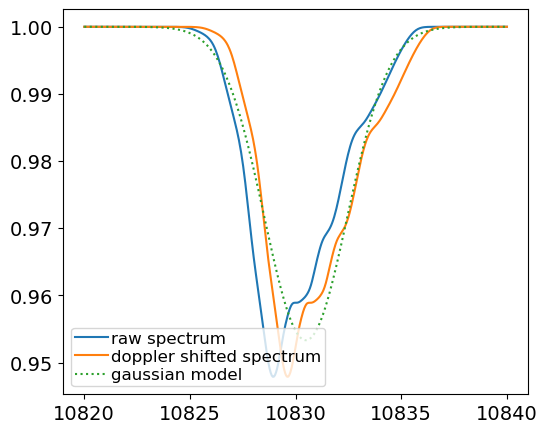

In [12]:
# MID-TRANSIT SPECTRUM

from astropy.modeling import models, fitting

#fn = "athena_simulation/PW_W12.out1.00015.athdf_l2_s9.0_Nmc50_Nr0.05_dtau_0.0_b_0.35_spectrum25_a0.0.txt"
fn = "athena_simulation/PW_W12.out1.00015.athdf_l2_s60.0_Nmc50_Nr0.05_dtau_0.0_b_0.35_spectrum25_a0.0.txt"
sp = ascii.read(fn,names=['lambda','flux'])

vlos = 18.75*1e5
lam_shift = sp['lambda']*(1+vlos/c.c)
sp_vshift_function = interp1d(lam_shift,sp['flux'],bounds_error=False,fill_value=1.0)


print(f"filter excess absorption (percent): {100*get_filter_abs(fn,vlos=vlos):.4f}" )

fit = fitting.LevMarLSQFitter()
mod_init = models.Gaussian1D(mean=10830.0)
xp = np.linspace(10820,10840,10000)
fm = fit(mod_init, xp, 1-sp_vshift_function(xp) )
print(fm)




xp = np.linspace(10820,10840,1000)
plt.plot(sp['lambda'],sp['flux'],label='raw spectrum')
plt.plot(xp,sp_vshift_function(xp),label='doppler shifted spectrum')
plt.plot(xp, 1-fm(xp),':', label='gaussian model')
#plt.plot(xp,filter_function(xp),label='filter profile')
plt.legend(loc='lower left')
plt.show()



In [13]:
#alist = np.concatenate( (np.flipud(-np.logspace(-2,0,21)),[0],np.logspace(-2,0,21)) )
alist = np.linspace(-1,1,41)
write_filter_LCT("athena_simulation/","PW_W12.out1.00015.athdf_l2_s60.0_Nmc50_Nr0.05_dtau_0.0_b_0.35_spectrum25",alist)    

wrote to: athena_simulation/PW_W12.out1.00015.athdf_l2_s9.0_Nmc50_Nr0.05_dtau_0.0_b_0.35_spectrum25_filter.dat


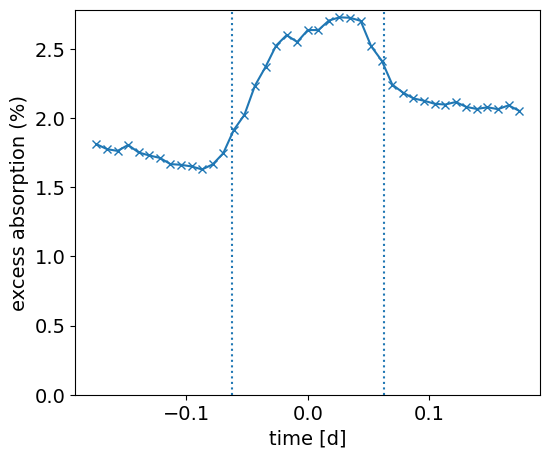

In [15]:
lc = ascii.read("athena_simulation/PW_W12.out1.00015.athdf_l2_s60.0_Nmc50_Nr0.05_dtau_0.0_b_0.35_spectrum25_filter.dat")
t14 = 2.9959/24 #d

plt.plot(lc['phase']*1.09142030,100*lc['ABS'],'x-')
#plt.semilogy()
plt.ylabel('excess absorption (%)')
plt.xlabel('time [d]')
plt.axvline(t14/2,ls=':')
plt.axvline(-t14/2,ls=':')
#plt.axhline(0.0005)
#plt.xlim(-0.2,0.2)
plt.ylim(0,)
#plt.grid()
plt.show()

# Paper Fig

In [16]:
orb = pw.read_trackfile("athena_simulation/pm_trackfile.dat")
rstar = 1.69*c.rsun
d,sep,b,sigma,vr = read_get_sigmab(base_dir="athena_simulation/",
                             fn="PW_W12.out1.00015.athdf",
                             level=4,
                             x1_min = rstar,
                             x1_max=4*a,
                             x3range = np.pi,
                             nanthresh=1e-10)

cs2 = c.G*orb['m2'][0]/(10*Rp)
print("T wind [K] = ",0.6*cs2*c.mp/c.kB)

SCALE = 60

/Users/morganmacleod/Library/CloudStorage/Dropbox/PlanetWind/Analysis/WASP-12b/Wasp12_hydro_model/athena_read.py:541: AthenaWarning: Requested refinement level higher than maximum level in file: all cells will be prolongated
  warnings.warn('Requested refinement level higher than maximum level in file:'


reading orbit file for planet wind simulation...
reading orbit file for planet wind simulation...
read_data...reading file athena_simulation/PW_W12.out1.00015.athdf
 ...file read, constructing arrays
 ...gamma= 1.0001
...getting cartesian arrays...
T wind [K] =  9778.320415288836


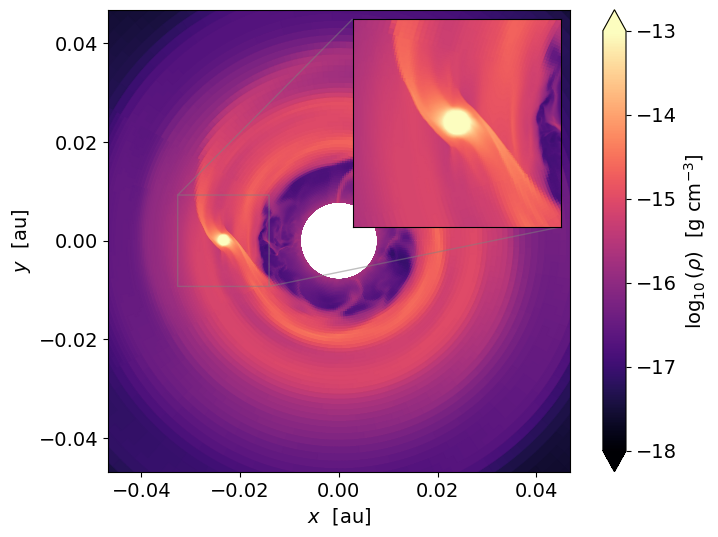

In [17]:
lim=2*a
myshade = 'gouraud'
fig,ax = plt.subplots(figsize=(8,6))

im = plt.pcolormesh(pw.get_plot_array_midplane(d['x'][:,0,:])/c.au,
           pw.get_plot_array_midplane(d['y'][:,0,:])/c.au,
           pw.get_plot_array_midplane(np.log10(d['rho'][:,0,:]*SCALE)),
           cmap='magma',
                    vmin=-18,vmax=-13,
                    shading=myshade,rasterized=True)

ax.set_aspect('equal')
ax.set_xlim(-lim/c.au,lim/c.au)
ax.set_ylim(-lim/c.au,lim/c.au)


axins = ax.inset_axes([0.53, 0.53, 0.45, 0.45])
axins.pcolormesh(pw.get_plot_array_midplane(d['x'][:,0,:])/c.au,
             pw.get_plot_array_midplane(d['y'][:,0,:])/c.au,
             pw.get_plot_array_midplane(np.log10(d['rho'][:,0,:]*SCALE)),
             cmap='magma',
                 vmin=-18,vmax=-13,
                 shading=myshade,rasterized=True)

# sub region of the original image
ilim = 10*Rp
axins.set_aspect('equal')
axins.set_xlim((-ilim-a)/c.au, (ilim-a)/c.au)
axins.set_ylim(-ilim/c.au, ilim/c.au)
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.set_xticks([])
axins.set_yticks([])
#plt.xticks(visible=False)
#plt.yticks(visible=False)
ax.indicate_inset_zoom(axins)


#ax.annotate(labellist[i],(0.05,0.9),xycoords='axes fraction',color='w')
ax.set_xlabel(r'$x \ \ [\rm {au}]$')
ax.set_ylabel(r'$y \ \ [\rm {au}]$')

    
fig.subplots_adjust(wspace=0.0,right=0.95)
#cax = fig.add_axes([0.96, 0.21, 0.01, 0.6])
cb=fig.colorbar(im,label=r'$\log_{10}\left(\rho \right) \ \ [{\rm g \ cm}^{-3}]$',extend='both')
cb.solids.set_edgecolor("face")
plt.savefig("WASP12_model_slice_3d.pdf",bbox_inches='tight',dpi=300)
plt.show()

mean out of transit excess [%] =  1.9137371468987616


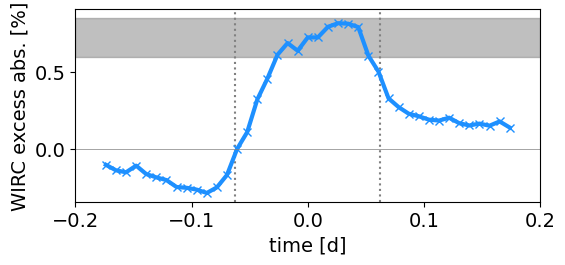

In [18]:
lc = ascii.read("athena_simulation/PW_W12.out1.00015.athdf_l2_s60.0_Nmc50_Nr0.05_dtau_0.0_b_0.35_spectrum25_filter.dat")
t14 = 2.9959/24 #d

out_of_transit_mean = np.mean( lc['ABS'][np.abs(lc['phase']*1.09142030)>0.1] )
print("mean out of transit excess [%] = ", out_of_transit_mean*100 )

plt.figure(figsize=(6,2.5))
plt.plot(lc['phase']*1.09142030,100*(lc['ABS']-out_of_transit_mean),'x-',lw=3,color='DodgerBlue')
plt.xlabel('time [d]')
plt.axhline(0.0,color='grey',lw=0.5)
plt.xlim(-0.2,0.2)
plt.ylabel('WIRC excess abs. [%]')
plt.fill_between([-0.2,0.2],0.73-0.13,0.73+0.12,color='grey',alpha=0.5)

plt.axvline(-t14/2,zorder=0,ls=":",color='grey')
plt.axvline(t14/2,zorder=0,ls=":",color='grey')
plt.savefig("WASP12_model_lc_3d.pdf",bbox_inches='tight')
plt.show()